# Sentiment Analysis on Twitter Dataset 
The task of the project is to classify tweets into three sentiments -- positive, neutral and negative.
We obtain the dataset from [semeval2014](http://alt.qcri.org/semeval2014/task9/) 

***Note*** To run this notebook, open it in a playground and then run all cells (Ctrl + F9)




Now we download the dataset into current working directory.

In [2]:
!wget https://raw.githubusercontent.com/laugustyniak/sas2015/master/data/SemEval-2014.csv

--2020-05-17 02:01:10--  https://raw.githubusercontent.com/laugustyniak/sas2015/master/data/SemEval-2014.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 794588 (776K) [text/plain]
Saving to: ‘SemEval-2014.csv.1’

SemEval-2014.csv.1  100%[===================>] 775.96K  --.-KB/s    in 0.07s   

2020-05-17 02:01:11 (10.9 MB/s) - ‘SemEval-2014.csv.1’ saved [794588/794588]



In [4]:
import torch
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from  torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We now read the data and show you how it looks.

In [9]:
data = pd.read_csv('SemEval-2014.csv', index_col=0)
data.head()

,sentiment,document
0,3,Gas by my house hit $3.39!!!! I'm going to Cha...
1,1,"Theo Walcott is still shit, watch Rafa and Joh..."
2,1,"its not that I'm a GSP fan, i just hate Nick D..."
3,1,Iranian general says Israel's Iron Dome can't ...
4,3,with J Davlar 11th. Main rivals are team Polan...


Now, we shall construct the vocabulary, tokenize the sentences, and calculate the maximum sentence length. \\
***Note***: after tokenization we remove the stop words and the puctuations. We also convert all words to lower case and also stem words.

In [7]:
vocab = set()
max_sent_len = 0
data_tokenized = []
data_label = []
porter = PorterStemmer()
for ind in data.index:
  data_label.append(int(data.sentiment[ind])-1)
  document = data.document[ind]
  doc_tokens = word_tokenize(document)
  # doc_tokens = [word.lower() for word in doc_tokens if word.isalpha()] # with out stemming 
  doc_tokens = [porter.stem(word) for word in doc_tokens if word.isalpha()]
  data_tokenized.append(doc_tokens)
  max_sent_len = max(max_sent_len, len(doc_tokens))
  vocab = vocab.union(set(doc_tokens))
print(len(vocab))
print(max_sent_len)

11962
198


We now have to make all the tokenised sentences equal to the maximum length of the sentances. We do this by padding the sentances by '\<pad>' token

In [0]:
def pad(sent: list, total_len:int, pad_token:str) -> list:
  return sent+[pad_token]*(total_len-len(sent))
pad_token = "<pad>"
vocab.add(pad_token)
# print(training_data_tokenized[1:10])
data_padded = list(map(lambda x: pad(x,max_sent_len,pad_token), data_tokenized))

For the ease of training we convert the padded string lists to int lists and create a map from the string tokens to unique integers

In [0]:
token_to_id = {token:i for i, token in enumerate(vocab)}
def conv_strlist_intlist(sent:list) -> list:
  return list(map(lambda x: token_to_id[x],sent))
data_padded_int = list(map(conv_strlist_intlist, data_padded))
# train_data_padded_int[0]

We now create a pytorch dataset for training purposes. Here we split the data into training and validation data in ratio of 9:1

In [13]:
class dataset(Dataset):
  def __init__(self, data:list, labels:list):
    super().__init__()
    self.data = np.array(data)
    self.labels = np.array(labels)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, i):
    return self.data[i,:], self.labels[i]
print(len(data_padded_int))
val_size = (len(data_padded_int))//10
print(val_size)
train_dataset = dataset(data_padded_int[:-val_size],data_label[:-val_size])
val_dataset = dataset(data_padded_int[val_size:],data_label[val_size:])

6265
626


We define our model below, it's a fully connected neural network along with a maxpooling layer over all the embeddings. We use the standard ReLU non-linearaty.
We also make use of an inbuild embedding layer. \\
We finalised the below model with extensive experimentation
 <!-- We use dropout as our regulariser -->

In [0]:
embedding_dem = 1024
class Model(nn.Module):
  def __init__(self, embedding_dim):
    super().__init__()
    self.embeding_layer = nn.Embedding(len(vocab),embedding_dim,padding_idx=token_to_id[pad_token]) #gives coressponding embeddings
    self.maxpool = nn.MaxPool1d(max_sent_len) #if l - lxEmbeding
    self.layers = [
                   nn.Linear(embedding_dim, 512),
                   nn.ReLU(),
                   nn.Linear(512,64),
                   nn.ReLU(),
                  #  nn.Dropout(),
                   nn.Linear(64,64),
                   nn.ReLU(),
                  #  nn.Dropout(),
                   nn.Linear(64,3)
    ]
    self.nn = nn.Sequential(*self.layers)
  def forward(self,x):
    x = self.embeding_layer(x)
    x = x.permute(0,2,1)
    x = self.maxpool(x)
    x = x.squeeze(-1)
    x = self.nn(x)
    return x

We define procedures for training and validation

In [0]:
def train_epoch(dataloader, model, optimizer, loss):
  average_loss = 0
  model.train()
  total_elements = 0
  total_accuracy = 0
  for batch, (data, label) in enumerate(dataloader):
    data = data.cuda()
    label = label.cuda()
    model.zero_grad()
    y = model(data)
    loss_ = loss(y,label)
    loss_.backward()
    optimizer.step()
    average_loss += loss_.detach().cpu().numpy()
    total_elements += label.shape[0]
    total_accuracy += torch.sum(y.argmax(axis = -1) == label).detach().cpu().numpy()
  batch += 1
  return average_loss/batch , total_accuracy/total_elements

def validate(dataloader, model, loss):
  with torch.no_grad():
    model.eval()
    total_accuracy = 0
    total_loss = 0
    total_elements = 0
    for batch, (data, label) in enumerate(dataloader):
      data = data.cuda()
      label = label.cuda()
      y = model(data)
      loss_ = loss(y, label)
      total_loss += loss_.detach().cpu().numpy()
      total_elements += label.shape[0]
      total_accuracy += torch.sum(y.argmax(axis = -1) == label).detach().cpu().numpy()
    batch +=1 
    return total_loss/batch, total_accuracy/total_elements

def train(train_dataloader, test_dataloader, num_epochs, model, optimizer, loss , lr_scheduler):
  train_losses = []
  train_accuracies = []
  validation_losses = []
  validation_accuracies = []
  for epoch in range(num_epochs):
    train_loss, training_accuracy = train_epoch(train_dataloader, model, optimizer, loss)
    validation_loss, validation_accuracy = validate(test_dataloader, model, loss)
    train_losses.append(train_loss)
    train_accuracies.append(training_accuracy)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)
    lr_scheduler.step()
    print(f'Epoch {epoch}, Training Loss is {train_loss},  validation loss is {validation_loss}')
  return train_losses,train_accuracies, validation_losses, validation_accuracies

We now train our model. We use the cross entopy loss and we use the Adam optimizer well known for it's quick convergance. We use exponential annealing for the learning rate for smoother training. With extensive experimentantion we find the hyperpareters in the code below. 

In [0]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset), shuffle=False)
num_epochs = 70
lr = 1e-3
model = Model(embedding_dem)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
model = model.cuda()
loss = nn.CrossEntropyLoss()
loss = loss.cuda()
train_losses, train_accuracies, validation_losses, validation_accuracies = \
          train(train_dataloader,val_dataloader,num_epochs, model, optimizer, loss, lr_scheduler)

# Plots
The below are the training plots. It can be seen that we achive convergence and also avoid overfitting 

 Final training accuracy is 0.9836850505408761, final validation accuracy is 0.9432523497073949


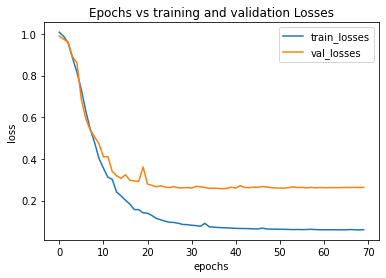

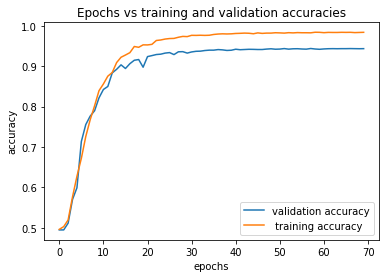

In [0]:
x = range(num_epochs)
plt.plot(x, train_losses,label="train_losses" )
plt.plot(x, validation_losses, label = "val_losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Epochs vs training and validation Losses")
plt.legend()
plt.figure()
plt.plot(x,validation_accuracies, label = "validation accuracy")
plt.plot(x, train_accuracies, label = " training accuracy")
plt.title("Epochs vs training and validation accuracies")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
print(f' Final training accuracy is {train_accuracies[-1]}, final validation accuracy is {validation_accuracies[-1]}')

# Conclusion 
We could achieve a training accuray of 98% and validation accuray of 94% using a simple neural network model. 